# PCM correlation models 
This demo is meant to show two common ways to use PCM correlation models to test hypotheses about the specific correlation between activity patterns. 

In the first part of this jupyter notebook, we'll focus on the question of how to estimate the true correlation between the activity patterns associated with 2 conditions. In the second part of this notebook, we will then turn to the slightly more complex situation in which we want to estimate the correlation between two **sets** of activity, for example the correlation between the activity pattern for the observation of 3 hand gestures with the activity pattern when the same 3 hand gestures are executed.

In [1]:
# First import necessary libraries
import PcmPy as pcm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import exp, sqrt
import scipy.stats as ss

## 1. Estimating the true correlation between two activity patterns or conditions

How similar are two activity patterns? It is easy to test whether 2 activity patterns are more correlated than 0. However, because of measurement noise, even if the two conditions elicit exactly the same pattern, the correlation will not be 1, simply because of measurement noise. Thus, it is very hard to estimate the **true** correlation between condition **A** and **B**. As explained in our blog [*Brain, Data, and Science*](http://diedrichsenlab.org/BrainDataScience/noisy_correlation), cross-validation does not result in unbiased estimates. To solve this problem, PCM turns this problem around: rather than asking which correlation is the best estimate given the data, let's instead ask how likely the data is given different levels of correlation. Thus, we will calculate the likelihood of the data given a range of specific correlations $p(Y|r)$, and then compare this likelihood across a range of correlation models. 

Other than setting the correlation values, we need to deal with a two additional parameters. 
- The strength (variance across voxels) of the activity patterns associated with condition **A**. 
- The strength (variance across voxels) of the activity patterns associated with condition **B**. 

The Noise model has one additional parameter
- The variance of the measurement noise across repeated measures of the same pattern. 

These hyper-parameters are collectively referred to by $\theta$ (thetas). Here we will compare different models by using the (Type II) maximum likelihood to approximate the model evidence:

$$
p(Y|r) \approx \underset{\theta}{\operatorname{max}}{p(Y|r,\theta)}.
$$

>These may seem like a bit of a cheat, but works in this this case quite well. Estimating parameters on the same data that you use to evaluate the model of course leads to an overestimation of the likelihood. However, as the number of hyper-parameters is low and all correlation models have the same number of parameters, this bias will be approximately stable across all models. 

>Since we are interested in the *difference* in log-likelihood across models, this small bias simply disappears. If you want to compare models with different numbers of parameters, a more sophisticated approach (such as group-cross-validation) is required. 

### 1.1 Simulating the data
We will use the PCM toolbox to simulate data from a given underlying true correlation model (M). We are using here a situation with only 2 conditions, which have a true correlation of 0.7. 

>Note that in `pcm.CorrelationModel` we set `num_items` to 1, as we have only 1 activity pattern per condition, and we set `cond_effect` to `False`, as we are not interested in subtracting out the overall effect between different conditions (each with multiple items, see section 2 below).

The model has 2 hyper-parameters (strength of each activity pattern) - and the noise model has an additional 1 hyper-parameter.

In [4]:

Mtrue = pcm.CorrelationModel('corr', num_items=1, corr=0.7, cond_effect=False)
print(f"The true model has {Mtrue.n_param} hyper parameters")

The true model has 2 hyper parameters


We can now use the simulation module to create 20 data sets with a relatively low signal to noise level.
We will use a design with 8 partitions. 

In [353]:
# Create the design. In this case it's 2 conditions, across 8 runs (partitions)!
cond_vec, part_vec = pcm.sim.make_design(n_cond=2, n_part=8)

# Starting from the true model above, generate 20 datasets/participants with relatively low signal-to-noise ratio (2:10)
D = pcm.sim.make_dataset(model=Mtrue, \
    theta=[1,2.7,0.4,0.2], \
    cond_vec=cond_vec, \
    part_vec=part_vec, \
    n_sim=20, \
    signal=0.2)

As we can see, the problem is that the empirical naïve correlation underestimates the true correlation substantially.
>The individually measured correlations (green dots) tend to remain below the true correlation (dashed horizontal line). As the signal/noise ratio decreases (moving leftward), this bias becomes more severe. In the extreme, when we have no signal, the correlation goes down to zero.

This is not a problem if we just want to test the hypothesis that the true correlation is larger than zero. Then we can just calculate the individual correlations per subject and test them against zero using a t-test. 

However, sometimes we want to test whether the true correlation has a specific value (for example , indicting that the activity patterns are the same), or we want to test whether the correlations are higher in one brain area than another. 

Different brain regions measured with fMRI often differ dramatically in their signal-to-noise ratio. Thus, in these cases we need to take into account our level of measurement noise. How can we do that?

### 1.2 Fitting the data


In [354]:
def get_noiseceil(X, cond_vec):
    """
        Calculate noise ceiling over reliabilities
    """
    rel = np.array([0.0, 0.0])
    for i in [0,1]:
        N = np.sum(cond_vec==i) # Number of measurements
        R = np.corrcoef(X[cond_vec==i,:]) # Correlation matrix
        index_R = np.where(~np.eye(N,dtype=bool)) # Average cross-block correlations
        r = np.mean(R[index_R]) # Average the non-diagnal elements
        rel[i] = r * N / (r*(N-1)+1) # Overall realibility of the mean

    # Check if both are above zero
    if rel[0]>0 and rel[1]>0:
        noise_r = np.sqrt(rel[0]*rel[1])
    else:
        noise_r = np.nan
    return noise_r

### 1.3 Interpreting the fit 
 we can use the cross-block information (crossvalidation) to caluculate correct coefficients. 

Here we use `est_G_crossval` to calculate those covariances:

In [355]:
def get_crossblock(X, cond_vec, part_vec):
    """
        calculate the cross-block correlation
    """
    G = pcm.util.est_G_crossval(X, cond_vec, part_vec)
    var = G[0][0,0]*G[0][1,1]
    if var<=0:
        crosscorr = np.nan
    else:
        crosscorr = G[0][0,1]/np.sqrt(var)
    return crosscorr

Now we need to extend our do_sim function to get these addtional measures.

In [356]:
def do_sim(corr, signal=np.linspace(0,5,20), n_sim=50, randseed=None):
    """
    Args:
        corr (float) - the true correlation value
        signal (np.ndarray) - array with a distribution of signal-to-noise ratio values
        n_sim (int) - number of simulations
        randseed (int) - use a specific seed to generate random data
    
    Returns:
        S (pd.dataframe) - output structure with len(signal)*n_sim rows
    """
    M = pcm.CorrelationModel('corr', num_items=1, corr=corr, cond_effect=False)
    G,dG = M.predict([0,0])
    cond_vec, part_vec = pcm.sim.make_design(2,2)
    Lcorr = []
    LnoiseCeil = []
    Lsign = []
    LcrossBlock =[]
    rng = np.random.default_rng(randseed)

    for s in signal:
        D = pcm.sim.make_dataset(M, [0,0], cond_vec, n_sim=n_sim, signal=s, rng=rng)
        for i in range(n_sim):
            data = D[i].measurements
            Lcorr.append(get_corr(data, cond_vec))
            LnoiseCeil.append(get_noiseceil(data, cond_vec))
            LcrossBlock.append(get_crossblock(data, cond_vec, part_vec))
            Lsign.append(s)
    S = pd.DataFrame({'r_naive':Lcorr, 'signal':Lsign,
                        'noiseCeil':LnoiseCeil, 'cross_block':LcrossBlock})
    S['true'] = np.ones((S.shape[0],))*corr
    return S

Now we can repeat the simulation.
>To get more reliable results the number of simulations should be increase to 10000.

In [357]:
# Define array of signal-to-noise ratio values
sig = np.array([0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9,1.5,2,2.5,3])
#sig = np.logspace(np.log(0.2),np.log(5),10)

# Repeat the simulation, add information to the dataframe
D = do_sim(0.7, n_sim=200, signal=sig, randseed=12)
D['noiseceil_nan'] = np.isnan(D.noiseCeil)
D['corr_corrected'] = D.r_naive / D.noiseCeil # Correction for noise ceiling 
D['corr_corrected_imp'] = D.corr_corrected
D.loc[np.isnan(D.corr_corrected), 'corr_corrected_imp'] = 0
D['cross_block_imp'] = D.cross_block
D.loc[np.isnan(D.cross_block), 'cross_block_imp'] = 0

# Group by signal-to-noise ratio levels
T = D.groupby("signal").apply(np.mean)
Tstd = D.groupby("signal").apply(np.std)
#display(T)

# Plot the figure
fig = plot_Figure3(D, T, Tstd)
#fig.update_layout(width=600, height=400)
fig.show()

As can be seen in the figure above the noise ceiling correction (solid blue line) works quite well if the signal-to-noise ratio is high. In this case the corrected estimate approaches the true correlation (black dashed line). For low signal-to-noise levels, however, the correction stops working correctly (and with fMRI we are usually in this domain). 

>What is going on on the left part of the plot? One problem is that in some cases correlations become negative, so that a real square root does not exist anymore. Here we have two options: either we exclude these values from further analysis (blue solid line), or we replaced them with a specific value, for example zero (blue dashed line). The former process is called exclusion, the latter is called imputation.

>Unfortunately, neither exclusion nor imputation fixes the problem. Both procedures show initially a negative bias for very low signal-to-noise values, switching into a positive bias for slightly higher signal-to-noise values. In general, the problem is that the estimates become quite unstable when one of the reliabilities gets small. 
 
The crossvalidated correlation (Figure 3, red lines) behaves very similar to the noise-ceiling corrected estimator (Figure 3, blue lines).

>Indeed, if you dig a bit through the math, you will realize that they differ only in one subtle way: solution 1a uses a ratio of correlations, whereas solution 1b uses a ratio of covariances instead. 

Again we have the problem that some of our variance estimator can become very small or negative, leading to the same issue of unstable or missing correlation estimates.

### 1.3 Solution 2: Using PCM correlation models
As we have seen, obtaining unbiased estimates of the true correlation is very tricky. The best solution therefore may be to turn the problem on its head: 



First we define a function that simulates data and then fits it with a series of PCM correlation models in the range [0 1].

In [358]:
def do_sim_corrpcm(corr=0.7, signal=0.5, n_sim=20, nsteps=11, randseed=None):
    """
    Args:
        corr (float) - the true correlation value
        signal (float) - the signal-to-noise ratio value
        n_sim (int) - number of simulations/participants
        nsteps (int) - number of correlation models between 0 and 1
        randseed (int) - use a specific seed to generate random data
    
    Returns:
        T (pd.dataframe) - output log-likelihoods with n_sim rows (subjects) and nsteps columns (models)
        theta (list) - list of values for parameters for each model fit
        M (list) - list of PCM correlation models
    """
    
    # Make the design: in this case it's 2 runs, 2 conditions
    cond_vec,part_vec = pcm.sim.make_design(2,2)
    # Generate different models from 0 to 1
    M=[]
    for r in np.linspace(0,1,nsteps):
        M.append(pcm.CorrelationModel(f"{r:0.2f}",num_items=1,corr=r,cond_effect=False))
    Mflex = pcm.CorrelationModel("flex",num_items=1,corr=None,cond_effect=False)
    M.append(Mflex)
    # Now do the simulations and fit with the models
    rng = np.random.default_rng(randseed)
    Mtrue = pcm.CorrelationModel('corr',num_items=1,corr=corr,cond_effect=False)
    D = pcm.sim.make_dataset(Mtrue, [0,0], cond_vec,part_vec=part_vec,n_sim=n_sim, signal=signal, rng=rng)
    T,theta = pcm.inference.fit_model_individ(D,M,fixed_effect=None,fit_scale=False,verbose = False)
    return T, theta, M

In [359]:
T, theta, M = do_sim_corrpcm(corr=0.7, signal=0.8, n_sim=20, nsteps=30, randseed=11)
fig = plot_Figure4(T, theta, M)
fig.update_layout(width=400, height=400)
fig.show()

Note that the log-likelihood values are quite negative—and differ substantially across data sets. This is normal—the only thing we can interpret are differences between log-likelihoods across the same data set for different models.

In [360]:
T.head()

variable likelihood                                                         \
model          0.00       0.03       0.07       0.10       0.14       0.17   
0        -89.145823 -88.847195 -88.557603 -88.276955 -88.005146 -87.742083   
1        -88.799972 -88.391631 -87.996685 -87.614541 -87.244694 -86.886726   
2        -80.450521 -80.282912 -80.120804 -79.964424 -79.813944 -79.669503   
3        -86.872787 -86.579574 -86.296412 -86.023052 -85.759278 -85.504909   
4        -91.595449 -91.312007 -91.036924 -90.770061 -90.511281 -90.260460   

variable                                              ... iterations       \
model          0.21       0.24       0.28       0.31  ...       0.72 0.76   
0        -87.487690 -87.241920 -87.004760 -86.776240  ...        3.0  3.0   
1        -86.540300 -86.205165 -85.881155 -85.568196  ...        4.0  4.0   
2        -79.531220 -79.399207 -79.273572 -79.154433  ...        3.0  3.0   
3        -85.259811 -85.023891 -84.797109 -84.579476  ...        4.0  4.0   
4        -90.017496 -89.782314 -89.554868 -89.335151  ...        4.0  4.0   

variable                                          
model    0.79 0.83 0.86 0.90 0.93 0.97 1.00 flex  
0         3.0  3.0  3.0  3.0  4.0  4.0  4.0  6.0  
1         4.0  4.0  4.0  4.0  4.0  4.0  4.0  6.0  
2         3.0  3.0  4.0  4.0  4.0  4.0  4.0  5.0  
3         4.0  3.0  3.0  3.0  4.0  4.0  4.0  5.0  
4         4.0  4.0  4.0  4.0  4.0  4.0  4.0  6.0  

[5 rows x 93 columns]

## 2. Testing for specific correlations between activity patterns across two conditions
In the second part of this notebook, we will simulate data from a hypothetical experiment, in which participants observed 3 hand gestures or executed the same 3 hand gestures.

>Thus, we have 3 items (i.e., the hand gestures) in each of 2 conditions (i.e., either observe or execute). 

We are interested in the average correlation between the patterns associated with observing and executing action A, observing and executing action B, and observing and executing action C, while accounting for overall differences in the average patterns of observing and executing. To solve this problem, we calculate the likelihood of the data given a range of specific correlations $p(Y|r)$.

Other than setting the correlation values, we need to deal with a few additional parameters. 
- First, the variance of the activity patterns associated with observing or executing different actions. These two hyper-parameters (one per condition but specific for each item) express the strength of the encoding and are directly related to the average inter-item distance in an RSA analysis.
- Second, we need to consider a pattern component that is caused by the condition itself (observing or executing actions), common to all items.
- Finally, we need a parameter that determines the noise variance. 

These hyper-parameters are collectively referred to by $\theta$ (thetas). Here we will compare different models by using the (Type II) maximum likelihood to approximate the model evidence:

$$
p(Y|r) \approx \underset{\theta}{\operatorname{max}}{p(Y|r,\theta)}.
$$

>These may seem like a bit of a cheat, but works in this this case quite well. Estimating parameters on the same data that you use to evaluate the model of course leads to an overestimation of the likelihood. However, as the number of hyper-parameters is low and all correlation models have the same number of parameters, this bias will be approximately stable across all models. 

>Since we are interested in the *difference* in log-likelihood across models, this small bias simply disappears. If you want to compare models with different numbers of parameters, a more sophisticated approach (such as group-cross-validation) is required. 

### 2.1 Data simulation
First, we create our true model: one where the all actions are equally strongly encoded in each conditions, but where the strength of encoding can differ between conditions. 

>For example, we could expect the difference between actions to be smaller during observation than during execution (simply due to overall levels of brain activation). 

Next, we also model the covariance between items within condition with a condition effect (i.e., by setting `condEffect` to `True`). Finally, we set the ground-truth correlation to be 0.7. 

In [362]:
Mtrue = pcm.CorrelationModel('corr', num_items=3, corr=0.7, cond_effect=True, within_cov=None)
print(f"The true model has {Mtrue.n_param} hyper parameters")

The true model has 4 hyper parameters


These four parameters are concerned with the condition effect and item effect for observation and execution, respectively. Visualizing the components of the second moment matrix (also known as variance-covariance, or simply covariance matrix) helps to understand this:

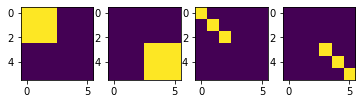

In [363]:
H = Mtrue.n_param
for i in range(H):
    plt.subplot(1,H,i+1)
    plt.imshow(Mtrue.Gc[i,:,:])

>The first two components plotted above reflect the condition effect and model the covariance between items within each condition (observation, execution). The second two components reflect the item effect and model the item-specific variance for each item (3 hand gestures) in each condition.

To Simulate a dataset, we need to simulate an experimental design. Let's assume we measure the 6 trial types (3 items x 2 conditions) in 8 imaging runs and submit the beta-values from each run to the model as $\mathbf{Y}$. 

We then generate a dataset where there is a strong overall effect for both observation (exp(0)) and execution (exp(1)). In comparison, the item-specific effects for observation (exp(-1.5)) and execution ((exp(-1))) are pretty weak (this is a rather typical finding).

>Note that all hyper parameters are log(variances)—this helps us to keep variances positive and the math easy. 

In [364]:
# Create the design. In this case it's 8 runs, 6 trial types!
cond_vec, part_vec = pcm.sim.make_design(n_cond=6, n_part=8)
#print(cond_vec)
#print(part_vec)

# Starting from the true model above, generate 20 datasets/participants with relatively low signal-to-noise ratio (2:10)
D = pcm.sim.make_dataset(model=Mtrue, \
    theta=[1,2.7,0.4,0.2], \
    cond_vec=cond_vec, \
    part_vec=part_vec, \
    n_sim=20, \
    signal=0.2)

As a quick check, let's plot the predicted second moment matrix of our true model (using the simulation parameters) and the crossvalidated estimate from the first dataset. 

Text(0.5, 1.0, 'dataset')

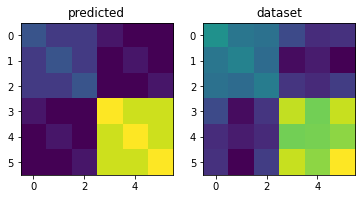

In [365]:
# Get the predicted G-matrix  from the true model
G,_ = Mtrue.predict([1,2.7,0.4,0.2])

# The estimated G-matrix from the first dataset 
trial_type = D[1].obs_descriptors['cond_vec']
G_hat,_ = pcm.est_G_crossval(D[1].measurements, trial_type, part_vec)

# Visualize the second moment (G) matrices
plt.subplot(1,2,1)
plt.imshow(G)
plt.title('predicted')

plt.subplot(1,2,2)
plt.imshow(G_hat)
plt.title('dataset')

### 2.2 Fitting the data 
Now we are fitting these datasets with a range of models, each assuming a correlation value between 0 and 1. The other parameters will still be included, as we did for the true model.

For comparison, we also include a flexible correlation model, which has a additional free parameter that models the correlation.

In [368]:
nsteps = 100 # how many correlation models?  
M = [] # initialize the output list M

# Generate the models equally spaced between 0 and 1 
for r in np.linspace(0, 1, nsteps):
    M.append(pcm.CorrelationModel(f"{r:0.2f}", num_items=3, corr=r, cond_effect=True))
    
# Now make the flexible model 
Mflex = pcm.CorrelationModel("flex", num_items=3, corr=None, cond_effect=True)
M.append(Mflex)

We can now fit the model to the datasets in one go. The resulting dataframe `T` has the log-likelihoods for each model / dataset. The second return argument `theta` contains the parameters for each model fit. 

In [369]:
# In this case, we model the block effect as a mixed effect
# We don't need to include a scale parameter given that we don't have a fixed model 
T, theta = pcm.fit_model_individ(D, M, fixed_effect='block', fit_scale=False, verbose=False)
T.head()

variable  likelihood                                                  \
model           0.00        0.01        0.02        0.03        0.04   
0        -932.260640 -932.052594 -931.847620 -931.645684 -931.446753   
1        -930.219463 -929.924336 -929.631674 -929.341427 -929.053542   
2        -926.276207 -926.061215 -925.848912 -925.639259 -925.432219   
3        -971.324724 -971.176116 -971.030165 -970.886846 -970.746132   
4        -927.725603 -927.506851 -927.290557 -927.076682 -926.865188   

variable                                                              ...  \
model           0.05        0.06        0.07        0.08        0.09  ...   
0        -931.250795 -931.057781 -930.867685 -930.680481 -930.496146  ...   
1        -928.767971 -928.484665 -928.203579 -927.924668 -927.647888  ...   
2        -925.227759 -925.025844 -924.826443 -924.629526 -924.435066  ...   
3        -970.608003 -970.472435 -970.339411 -970.208912 -970.080921  ...   
4        -926.656039 -926.449199 -926.244637 -926.042319 -925.842216  ...   

variable iterations                                               
model          0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.00 flex  
0               5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  
1               5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  7.0  
2               5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  
3               5.0  5.0  5.0  5.0  5.0  5.0  5.0  6.0  6.0  5.0  
4               5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  

[5 rows x 303 columns]

### 2.3 Interpreting the Fit 
Again, note that the absolute values of the log-likelihoods don't mean much. Therefore, first, we remove the mean log-likelihood for each correlation model, expressing each log-likelihood as the difference against the mean. 

Next, we plot the full log-likelihood curves (solid lines) and the maximum likelihood estimate (filled circles) of the correlation for each participant. We can also add the mean log-likelihood curve (dotted line) and the mean of the maximum log-likelihood estimates (vertical blue line) across participants.

Text(0, 0.5, 'log-likelihood')

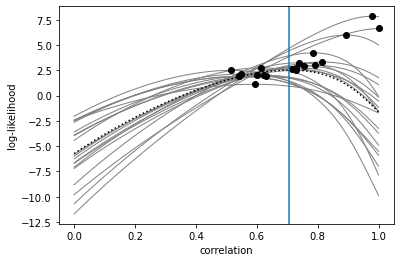

In [370]:
L = T.likelihood.to_numpy()

# express log-likelihoods relative to mean 
L = L - L.mean(axis=1).reshape(-1,1)
maxL = L[:,-1] # Last model is the flexible 
L = L[:,0:-1] # Remove it 

# Get the correlation for each of the models
r = np.empty((nsteps,))
for i in range(nsteps):
    r[i]= M[i].corr

# Get the maximum likelihood estimate of each parameter 
maxr = M[-1].get_correlation(theta[-1])

# Now we make the plot 
plt.plot(r,L.T,color='gray', marker=None, linewidth=1)
plt.plot(maxr,maxL,'k.',markersize=12)
plt.plot(r,L.mean(axis=0),'k:')
plt.axvline(maxr.mean())
plt.xlabel('correlation')
plt.ylabel('log-likelihood')

As we can see, the maximum log-likelihood estimates behave quite well, but the mean of the maximum log-likelihood estimates (vertical line) is not exactly where the maximum of the mean (or group) log-likelihood lies (peak of the mean log-likelihood curve). 

One way to use the log-likelihoods is to do a paired-samples t-test between the log-likelihoods for two correlation values. For example, 0.7 vs 0.3:

In [207]:
print(f"Testing correlation of {r[69]:0.2f} against {r[30]:0.2f}")
t, p = ss.ttest_rel(L[:,69],L[:,30])
print(f'nPaired-samples t-test: t({len(L)-1})={t:1.3f}; p({len(L)-1})={p:1.6f}')

Testing correlation of 0.70 against 0.30
nPaired-samples t-test: t(19)=3.585; p(19)=0.001973


Alternatively, we can transform the log-likelihoods in approximate posterior distributions, and proceed with a Full Bayesian group analysis. 
For more accurate results, you probably want to space your correlation models more tightly.

Text(0, 0.5, 'posterior probability')

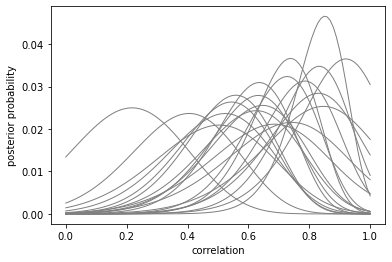

In [208]:
P = exp(L) # Take the exponential of the log-likelihoods
P = P / P.sum(axis=1).reshape(-1,1) # Normalize to 1 over domain 
plt.plot(r,P.T,color='gray', marker=None, linewidth=1)
plt.xlabel('correlation')
plt.ylabel('posterior probability')